In [1]:
# Imports
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from transformers import logging
logging.set_verbosity_error()

from A01_model_audio import get_audio_val_loader, get_audio_test_loader, get_audio_preds
from A02_model_text import get_text_val_loader, get_text_test_loader, get_text_preds
from A03_model_tab_features import get_tabular_preds, get_tabular_test_preds

In [2]:
# Loading device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Calibrate Probs
def calibrate_probs(probs, labels):
    """Calibrate probabilities using isotonic regression."""
    # Use a dummy classifier for calibration; fit on validation data
    clf = LogisticRegression()
    clf.fit(probs.reshape(-1, 1), labels)
    cal = CalibratedClassifierCV(clf, method='isotonic', cv='prefit')
    cal.fit(probs.reshape(-1, 1), labels)
    return cal.predict_proba(probs.reshape(-1, 1))[:, 1]

In [4]:
# For Audio Modality
def aggregate_audio(audio_preds, audio_labels, audio_part_ids):
    participant_probs = defaultdict(list)
    participant_labels = {}
    for prob, label, pid in zip(audio_preds, audio_labels, audio_part_ids):
        participant_probs[pid].append(prob)
        participant_labels[pid] = label
    audio_probs_agg = []
    audio_labels_agg = []
    for pid in sorted(participant_probs.keys()):
        audio_probs_agg.append(np.mean(participant_probs[pid]))
        audio_labels_agg.append(participant_labels[pid])
    return np.array(audio_probs_agg), np.array(audio_labels_agg)

# Load dataloaders
audio_val_loader = get_audio_val_loader()
audio_test_loader = get_audio_test_loader()

print("Generating audio predictions...")
audio_preds, audio_labels, audio_part_ids = get_audio_preds(audio_val_loader, device=device)
audio_test_preds, audio_test_labels, audio_test_part_ids = get_audio_preds(audio_test_loader, device=device)

# Aggregate audio predictions per participant
audio_probs_agg, audio_labels_agg = aggregate_audio(audio_preds, audio_labels, audio_part_ids)
audio_test_probs_agg, audio_test_labels_agg = aggregate_audio(audio_test_preds, audio_test_labels, audio_test_part_ids)

# Calibrate probabilities for audio
print("Calibrating audio probabilities...")
audio_probs_cal = calibrate_probs(audio_probs_agg, audio_labels_agg)
audio_test_probs_cal = calibrate_probs(audio_test_probs_agg, audio_test_labels_agg)

print("Audio modality is ready!")

Generating audio predictions...
Calibrating audio probabilities...
Audio modality is ready!


In [5]:
# For Text Modality
def aggregate_text(preds, labels, part_ids):
    participant_probs = defaultdict(list)
    participant_labels = {}
    for prob, label, pid in zip(preds, labels, part_ids):
        participant_probs[pid].append(prob)
        participant_labels[pid] = label
    probs_agg = []
    labels_agg = []
    for pid in sorted(participant_probs.keys()):
        probs_agg.append(np.mean(participant_probs[pid]))
        labels_agg.append(participant_labels[pid])
    return np.array(probs_agg), np.array(labels_agg)

# Load dataloaders
text_val_loader = get_text_val_loader()
text_test_loader = get_text_test_loader()

print("Generating text predictions...")
text_preds, text_labels, text_part_ids = get_text_preds(text_val_loader, device=device)
text_test_preds, text_test_labels, text_test_part_ids = get_text_preds(text_test_loader, device=device)

# Aggregate per participant
text_probs_agg, text_labels_agg = aggregate_text(text_preds, text_labels, text_part_ids)
text_test_probs_agg, text_test_labels_agg = aggregate_text(text_test_preds, text_test_labels, text_test_part_ids)

# Calibrate probabilities for text
print("Calibrating text probabilities...")
text_probs_cal = calibrate_probs(text_probs_agg, text_labels_agg)
text_test_probs_cal = calibrate_probs(text_test_probs_agg, text_test_labels_agg)

print("Text modality is ready!")

Generating text predictions...
Calibrating text probabilities...
Text modality is ready!


In [6]:
# For Tabular Modality
print("Generating tabular predictions...")
tabular_preds, tabular_labels, tabular_part_ids = get_tabular_preds()
tabular_test_preds, tabular_test_labels, tabular_test_part_ids = get_tabular_test_preds()

# Correct sorting
sorted_indices = np.argsort(tabular_part_ids)
tabular_part_ids = tabular_part_ids[sorted_indices]
tabular_preds = tabular_preds[sorted_indices]
tabular_labels = tabular_labels[sorted_indices]

sorted_indices = np.argsort(tabular_test_part_ids)
tabular_test_part_ids = tabular_test_part_ids[sorted_indices]
tabular_test_preds = tabular_test_preds[sorted_indices]
tabular_test_labels = tabular_test_labels[sorted_indices]

# Calibrate probabilities for tabular
print("Calibrating tabular probabilities...")
tabular_probs_cal = calibrate_probs(tabular_preds, tabular_labels)
tabular_test_probs_cal = calibrate_probs(tabular_test_preds, tabular_test_labels)

print("Tabular modality is ready!")

Generating tabular predictions...
Calibrating tabular probabilities...
Tabular modality is ready!


In [7]:
# Check Labels
print("Audio labels shape (chunk-level):", audio_labels.shape)
print("Audio labels shape (participant-level):", audio_labels_agg.shape)
print("Text labels shape:", text_labels.shape)
print("Text labels shape:", text_labels_agg.shape)
print("Tabular labels shape:", tabular_labels.shape)

print("")

print("Audio unique labels:", np.unique(audio_labels_agg))
print("Text unique labels:", np.unique(text_labels))
print("Tabular unique labels:", np.unique(tabular_labels))

print("\nEverything ready for fusion.")

Audio labels shape (chunk-level): (2351,)
Audio labels shape (participant-level): (35,)
Text labels shape: (555,)
Text labels shape: (35,)
Tabular labels shape: (35,)

Audio unique labels: [0 1]
Text unique labels: [0 1]
Tabular unique labels: [0 1]

Everything ready for fusion.


In [8]:
# Late fusion for two modalities
def late_fusion_two(first_probs, second_probs, method='weighted', alpha=0.7, labels=None, clf=None):
    X = np.stack([first_probs, second_probs], axis=1)
    if method == 'weighted':
        fused_probs = alpha * first_probs + (1 - alpha) * second_probs
    elif method == 'average':
        fused_probs = X.mean(axis=1)
    elif method == 'logistic':
        if clf is None:
            raise ValueError("Logistic model (clf) must be provided for logistic fusion.")
        fused_probs = clf.predict_proba(X)[:, 1]
    else:
        raise ValueError(f"Unknown fusion method: {method}")
    return fused_probs

def tune_alpha_and_threshold_two(first_probs, second_probs, labels, method='weighted'):
    best_macro_f1 = 0
    best_alpha = None
    best_thresh = 0.5
    best_report = ""
    best_preds = None
    best_clf = None 

    if method == 'logistic':
        # Train logistic regression on validation set
        X = np.stack([first_probs, second_probs], axis=1)
        clf = LogisticRegression()
        clf.fit(X, labels)
        
        calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv='prefit')
        calibrated_clf.fit(X, labels)
        
        fused_probs = calibrated_clf.predict_proba(X)[:, 1]

        # Tune threshold only
        for thresh in np.arange(0.1, 0.9, 0.01):
            fused_preds = (fused_probs >= thresh).astype(int)
            macro_f1 = f1_score(labels, fused_preds, average='macro')
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                best_thresh = thresh
                best_report = classification_report(labels, fused_preds, target_names=["not depressed", "depressed"])
                best_preds = fused_preds
                best_clf = calibrated_clf
    else:
        # Tune alpha and threshold
        alphas = [0.5] if method == 'average' else np.arange(0.3, 0.7, 0.05)
        for alpha in alphas:
            fused_probs = late_fusion_two(first_probs, second_probs, method=method, alpha=alpha, labels=labels)
            for thresh in np.arange(0.1, 0.5, 0.01):
                fused_preds = (fused_probs >= thresh).astype(int)
                macro_f1 = f1_score(labels, fused_preds, average='macro')
                if macro_f1 > best_macro_f1:
                    best_macro_f1 = macro_f1
                    best_alpha = alpha
                    best_thresh = thresh
                    best_report = classification_report(labels, fused_preds, target_names=["not depressed", "depressed"])
                    best_preds = fused_preds

    return best_alpha, best_thresh, best_macro_f1, best_report, best_preds, best_clf

In [57]:
### Late fusion on audio and text ###
assert np.array_equal(audio_labels_agg, text_labels_agg), "Mismatch in ground truth labels!"

fusion_method = 'logistic'

# Tune alpha and threshold for best macro F
print("Tuning alpha and threshold for weighted late fusion...")
best_alpha, best_thresh, best_macro_f1, best_report, best_preds, best_clf = tune_alpha_and_threshold_two(
    audio_probs_cal, text_probs_cal, audio_labels_agg, method=fusion_method
)

if best_alpha is not None:
    print(f"\nBest alpha (audio): {best_alpha:.2f}")
    print(f"Best beta (text): {(1 - best_alpha):.2f}")
else:
    print("\nAlpha not used (logistic fusion)")
    
print(f"\nBest threshold: {best_thresh:.2f}")
print(f"Best macro F1: {best_macro_f1:.4f}")
print("\nClassification Report (Audio / Text):")
print(best_report)

Tuning alpha and threshold for weighted late fusion...

Alpha not used (logistic fusion)

Best threshold: 0.39
Best macro F1: 0.7619

Classification Report (Audio / Text):
               precision    recall  f1-score   support

not depressed       0.81      0.91      0.86        23
    depressed       0.78      0.58      0.67        12

     accuracy                           0.80        35
    macro avg       0.79      0.75      0.76        35
 weighted avg       0.80      0.80      0.79        35



In [10]:
# Classification Report (Audio / Text):
#                precision    recall  f1-score   support

# not depressed       0.86      0.78      0.82        23
#     depressed       0.64      0.75      0.69        12

#      accuracy                           0.77        35
#     macro avg       0.75      0.77      0.76        35
#  weighted avg       0.78      0.77      0.78        35

In [58]:
# Fuse test probs with best alpha from validation
if fusion_method == 'logistic' and best_clf is not None:
    test_fused_probs = late_fusion_two(
        audio_test_probs_cal, text_test_probs_cal,
        method='logistic',
        clf=best_clf
    )
elif fusion_method == 'weighted':
    test_fused_probs = late_fusion_two(
        audio_test_probs_cal, text_test_probs_cal,
        method='weighted',
        alpha=best_alpha
    )
elif fusion_method == 'average':
    test_fused_probs = late_fusion_two(
        audio_test_probs_cal, text_test_probs_cal,
        method='average'
    )
else:
    raise ValueError("Unknown fusion method")

# Threshold and print classification report
test_auroc = roc_auc_score(audio_test_labels_agg, test_fused_probs)
test_preds = (test_fused_probs >= best_thresh).astype(int)

print(f"Method: {fusion_method}")
print(f"Test AUROC (Audio / Text): {test_auroc:.4f}")
print("Test Classification Report (Audio / Text):")
print(classification_report(audio_test_labels_agg, test_preds, target_names=["not depressed", "depressed"]))

Method: logistic
Test AUROC (Audio / Text): 0.7344
Test Classification Report (Audio / Text):
               precision    recall  f1-score   support

not depressed       0.82      0.88      0.85        32
    depressed       0.67      0.57      0.62        14

     accuracy                           0.78        46
    macro avg       0.75      0.72      0.73        46
 weighted avg       0.78      0.78      0.78        46



In [12]:
# Test AUROC (Audio / Text): 0.7042

# Test Classification Report (Audio / Text):
#                precision    recall  f1-score   support

# not depressed       0.78      0.88      0.82        32
#     depressed       0.60      0.43      0.50        14

#      accuracy                           0.74        46
#     macro avg       0.69      0.65      0.66        46
#  weighted avg       0.72      0.74      0.73        46

In [65]:
### Late fusion on audio and tabular ###
assert np.array_equal(audio_labels_agg, tabular_labels), "Mismatch in ground truth labels!"

fusion_method = 'weighted'

# Tune alpha and threshold for best macro F
print("Tuning alpha and threshold for weighted late fusion...")
best_alpha, best_thresh, best_macro_f1, best_report, best_preds, best_clf = tune_alpha_and_threshold_two(
    audio_probs_cal, tabular_probs_cal, audio_labels_agg, method=fusion_method
)

if best_alpha is not None:
    print(f"\nBest alpha (audio): {best_alpha:.2f}")
    print(f"Best beta (tabular): {(1 - best_alpha):.2f}")
else:
    print("\nAlpha not used (logistic fusion)")
    
print(f"\nBest threshold: {best_thresh:.2f}")
print(f"Best macro F1: {best_macro_f1:.4f}")
print("\nClassification Report (Audio / Tabular):")
print(best_report)

Tuning alpha and threshold for weighted late fusion...

Best alpha (audio): 0.35
Best beta (tabular): 0.65

Best threshold: 0.36
Best macro F1: 0.7348

Classification Report (Audio / Tabular):
               precision    recall  f1-score   support

not depressed       0.80      0.87      0.83        23
    depressed       0.70      0.58      0.64        12

     accuracy                           0.77        35
    macro avg       0.75      0.73      0.73        35
 weighted avg       0.77      0.77      0.77        35



In [14]:
# Tuning alpha and threshold for weighted late fusion...

# Best alpha: 0.50
# Best threshold: 0.43
# Best macro F1: 0.7009

# Classification Report (Audio / Tabular):
#                precision    recall  f1-score   support

# not depressed       0.76      0.96      0.85        23
#     depressed       0.83      0.42      0.56        12

#      accuracy                           0.77        35
#     macro avg       0.80      0.69      0.70        35
#  weighted avg       0.78      0.77      0.75        35

In [66]:
# Fuse test probs with best alpha from validation
if fusion_method == 'logistic' and best_clf is not None:
    test_fused_probs = late_fusion_two(
        audio_test_probs_cal, tabular_test_probs_cal,
        method='logistic',
        clf=best_clf
    )
elif fusion_method == 'weighted':
    test_fused_probs = late_fusion_two(
        audio_test_probs_cal, tabular_test_probs_cal,
        method='weighted',
        alpha=best_alpha
    )
elif fusion_method == 'average':
    test_fused_probs = late_fusion_two(
        audio_test_probs_cal, tabular_test_probs_cal,
        method='average'
    )
else:
    raise ValueError("Unknown fusion method")

# Threshold and print classification report
test_auroc = roc_auc_score(audio_test_labels_agg, test_fused_probs)
test_preds = (test_fused_probs >= best_thresh).astype(int)
print(f"Test AUROC (Audio / Tabular): {test_auroc:.4f}")
print("\nTest Classification Report (Audio / Tabular):")
print(classification_report(audio_test_labels_agg, test_preds, target_names=["not depressed", "depressed"]))

Test AUROC (Audio / Tabular): 0.8371

Test Classification Report (Audio / Tabular):
               precision    recall  f1-score   support

not depressed       0.81      0.91      0.85        32
    depressed       0.70      0.50      0.58        14

     accuracy                           0.78        46
    macro avg       0.75      0.70      0.72        46
 weighted avg       0.77      0.78      0.77        46



In [16]:
# Test AUROC (Audio / Tabular): 0.7076

# Test Classification Report (Audio / Tabular):
#                precision    recall  f1-score   support

# not depressed       0.75      0.84      0.79        32
#     depressed       0.50      0.36      0.42        14

#      accuracy                           0.70        46
#     macro avg       0.62      0.60      0.61        46
#  weighted avg       0.67      0.70      0.68        46

In [71]:
### Late fusion on text and tabular ###
assert np.array_equal(text_labels_agg, tabular_labels), "Mismatch in ground truth labels!"

fusion_method = 'average'

# Tune alpha and threshold for best macro F
print("Tuning alpha and threshold for weighted late fusion...")
best_alpha, best_thresh, best_macro_f1, best_report, best_preds, best_clf = tune_alpha_and_threshold_two(
    text_probs_cal, tabular_probs_cal, audio_labels_agg, method=fusion_method
)

if best_alpha is not None:
    print(f"\nBest alpha (text): {best_alpha:.2f}")
    print(f"Best beta (tabular): {(1 - best_alpha):.2f}")
else:
    print("\nAlpha not used (logistic fusion)")

print(f"\nBest threshold: {best_thresh:.2f}")
print(f"Best macro F1: {best_macro_f1:.4f}")
print("\nClassification Report (Text / Tabular):")
print(best_report)

Tuning alpha and threshold for weighted late fusion...

Best alpha (text): 0.50
Best beta (tabular): 0.50

Best threshold: 0.38
Best macro F1: 0.7348

Classification Report (Text / Tabular):
               precision    recall  f1-score   support

not depressed       0.80      0.87      0.83        23
    depressed       0.70      0.58      0.64        12

     accuracy                           0.77        35
    macro avg       0.75      0.73      0.73        35
 weighted avg       0.77      0.77      0.77        35



In [18]:
# Classification Report (Text / Tabular):
#                precision    recall  f1-score   support

# not depressed       0.76      0.96      0.85        23
#     depressed       0.83      0.42      0.56        12

#      accuracy                           0.77        35
#     macro avg       0.80      0.69      0.70        35
#  weighted avg       0.78      0.77      0.75        35

In [72]:
# Fuse test probs with best alpha from validation
if fusion_method == 'logistic' and best_clf is not None:
    test_fused_probs = late_fusion_two(
        text_test_probs_cal, tabular_test_probs_cal,
        method='logistic',
        clf=best_clf
    )
elif fusion_method == 'weighted':
    test_fused_probs = late_fusion_two(
        text_test_probs_cal, tabular_test_probs_cal,
        method='weighted',
        alpha=best_alpha
    )
elif fusion_method == 'average':
    test_fused_probs = late_fusion_two(
        text_test_probs_cal, tabular_test_probs_cal,
        method='average'
    )
else:
    raise ValueError("Unknown fusion method")

# Threshold and print classification report
test_auroc = roc_auc_score(audio_test_labels_agg, test_fused_probs)
test_preds = (test_fused_probs >= best_thresh).astype(int)
print(f"Test set AUROC (Text + Tabular): {test_auroc:.4f}")
print("\nTest Classification Report (Text / Text):")
print(classification_report(audio_test_labels_agg, test_preds, target_names=["not depressed", "depressed"]))

Test set AUROC (Text + Tabular): 0.7154

Test Classification Report (Text / Text):
               precision    recall  f1-score   support

not depressed       0.79      0.81      0.80        32
    depressed       0.54      0.50      0.52        14

     accuracy                           0.72        46
    macro avg       0.66      0.66      0.66        46
 weighted avg       0.71      0.72      0.71        46



In [20]:
# Test set AUROC (Text + Tabular): 0.7433

# Test Classification Report (Text / Text):
#                precision    recall  f1-score   support

# not depressed       0.75      0.94      0.83        32
#     depressed       0.67      0.29      0.40        14

#      accuracy                           0.74        46
#     macro avg       0.71      0.61      0.62        46
#  weighted avg       0.72      0.74      0.70        46

In [21]:
### Late fusion on all three modalities ###

In [51]:
def late_fusion_three(audio_probs, text_probs, tabular_probs, method='weighted', alpha=0.4, beta=0.4, labels=None, clf=None):
    X = np.stack([audio_probs, text_probs, tabular_probs], axis=1)
    if method == 'weighted':
        gamma = 1 - alpha - beta
        fused_probs = alpha * audio_probs + beta * text_probs + gamma * tabular_probs
    elif method == 'average':
        fused_probs = X.mean(axis=1)
    elif method == 'logistic':
        if clf is None:
            raise ValueError("Logistic model (clf) must be provided for logistic fusion.")
        fused_probs = clf.predict_proba(X)[:, 1]
    else:
        raise ValueError(f"Unknown fusion method: {method}")
    return fused_probs

def tune_alpha_beta_threshold_three(audio_probs, text_probs, tabular_probs, labels, method='weighted'):
    best_macro_f1 = 0
    best_alpha = None
    best_beta = None
    best_thresh = 0.5
    best_report = ""
    best_preds = None
    best_probs = None
    best_clf = None 
    
    if method == 'logistic':
        # Train logistic regression on validation set
        X = np.stack([audio_probs, text_probs, tabular_probs], axis=1)
        clf = LogisticRegression()
        clf.fit(X, labels)
        
        calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv='prefit')
        calibrated_clf.fit(X, labels)
        
        fused_probs = calibrated_clf.predict_proba(X)[:, 1]

        # Tune threshold only
        for thresh in np.arange(0.1, 0.9, 0.01):
            fused_preds = (fused_probs >= thresh).astype(int)
            macro_f1 = f1_score(labels, fused_preds, average='macro')
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                best_thresh = thresh
                best_report = classification_report(labels, fused_preds, target_names=["not depressed", "depressed"])
                best_preds = fused_preds
                best_clf = calibrated_clf
    else:
        # Search over reasonable ranges for alpha, beta, and threshold
        alphas = [0.33] if method == 'average' else np.arange(0.1, 0.5, 0.05)
        betas = [0.33] if method == 'average' else np.arange(0.1, 0.5, 0.05)
        for alpha in alphas:
            for beta in betas:
                if alpha + beta >= 1.0:
                    continue
                fused_probs = late_fusion_three(audio_probs, text_probs, tabular_probs, method=method, alpha=alpha, beta=beta, labels=labels)

                for thresh in np.arange(0.0, 0.9, 0.01):
                    fused_preds = (fused_probs >= thresh).astype(int)
                    macro_f1 = f1_score(labels, fused_preds, average='macro')
                    if macro_f1 > best_macro_f1:
                        best_macro_f1 = macro_f1
                        best_alpha = alpha
                        best_beta = beta
                        best_thresh = thresh
                        best_report = classification_report(labels, fused_preds, target_names=["not depressed", "depressed"])
                        best_preds = fused_preds
                        best_probs = fused_probs
    
    return best_alpha, best_beta, best_thresh, best_macro_f1, best_report, best_preds, best_probs, best_clf

assert np.array_equal(audio_labels_agg, text_labels_agg) and np.array_equal(tabular_labels, text_labels_agg), \
    "Mismatch in labels across modalities (audio, text, tabular)!"

fusion_method = 'logistic'

# Tune alpha and threshold for best macro F
print("Tuning alpha and threshold for weighted late fusion...")
best_alpha, best_beta, best_thresh, best_macro_f1, best_report, best_preds, best_probs, best_clf = tune_alpha_beta_threshold_three(
    audio_probs_cal, text_probs_cal, tabular_probs_cal, text_labels_agg, method=fusion_method
)

if best_alpha is not None:
    print(f"\nBest alpha (audio): {best_alpha:.2f}")
    print(f"Best beta (text): {best_beta:.2f}")
    print(f"Best gamma (tabular): {(1.0 - best_alpha - best_beta):.2f}")
else:
    print("\nAlpha and Beta not used (logistic fusion)")
    
print(f"\nBest threshold: {best_thresh:.2f}")
print(f"Best macro F1: {best_macro_f1:.4f}")
print("\nClassification Report (Audio / Text / Tabular):")
print(best_report)

Tuning alpha and threshold for weighted late fusion...

Alpha and Beta not used (logistic fusion)

Best threshold: 0.28
Best macro F1: 0.8098

Classification Report (Audio / Text / Tabular):
               precision    recall  f1-score   support

not depressed       0.87      0.87      0.87        23
    depressed       0.75      0.75      0.75        12

     accuracy                           0.83        35
    macro avg       0.81      0.81      0.81        35
 weighted avg       0.83      0.83      0.83        35



In [23]:
# Classification Report (Audio / Text / Tabular):
#                precision    recall  f1-score   support

# not depressed       0.81      0.91      0.86        23
#     depressed       0.78      0.58      0.67        12

#      accuracy                           0.80        35
#     macro avg       0.79      0.75      0.76        35
#  weighted avg       0.80      0.80      0.79        35

In [52]:
if fusion_method == 'logistic' and best_clf is not None:
    test_fused_probs = late_fusion_three(
        audio_test_probs_cal,
        text_test_probs_cal,
        tabular_test_probs_cal,
        method='logistic',
        clf=best_clf,
        labels=audio_test_labels_agg
    )
elif fusion_method == 'weighted':
    test_fused_probs = late_fusion_three(
        audio_test_probs_cal,
        text_test_probs_cal,
        tabular_test_probs_cal,
        method='weighted',
        alpha=best_alpha,
        beta=best_beta,
        labels=audio_test_labels_agg
    )
elif fusion_method == 'average':
    test_fused_probs = late_fusion_three(
        audio_test_probs_cal,
        text_test_probs_cal,
        tabular_test_probs_cal,
        method='average',
        labels=audio_test_labels_agg
    )
else:
    raise ValueError("Unknown fusion method")

# Threshold and print classification report
test_auroc = roc_auc_score(audio_test_labels_agg, test_fused_probs)
test_preds = (test_fused_probs >= best_thresh).astype(int)

print(f"Test AUROC (Audio + Text + Tabular): {test_auroc:.4f}")
print("\nTest Classification Report (Audio / Text / Tabular):")

print(classification_report(audio_test_labels_agg, test_preds, target_names=["not depressed", "depressed"]))

Test AUROC (Audio + Text + Tabular): 0.8750

Test Classification Report (Audio / Text / Tabular):
               precision    recall  f1-score   support

not depressed       0.83      0.91      0.87        32
    depressed       0.73      0.57      0.64        14

     accuracy                           0.80        46
    macro avg       0.78      0.74      0.75        46
 weighted avg       0.80      0.80      0.80        46



In [25]:
# Test AUROC (Audio + Text + Tabular): 0.7768

# Test Classification Report (Audio / Text / Tabular):
#                precision    recall  f1-score   support

# not depressed       0.81      0.91      0.85        32
#     depressed       0.70      0.50      0.58        14

#      accuracy                           0.78        46
#     macro avg       0.75      0.70      0.72        46
#  weighted avg       0.77      0.78      0.77        46

In [156]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import os

alpha = 0.05
Your_class = 'Depression'

y_test_i = audio_test_labels_agg
y_val_i = audio_labels_agg
y_test_preds = test_fused_probs
y_val_preds = best_probs

base_auc = roc_auc_score(y_test_i, y_test_preds)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 690.56it/s]


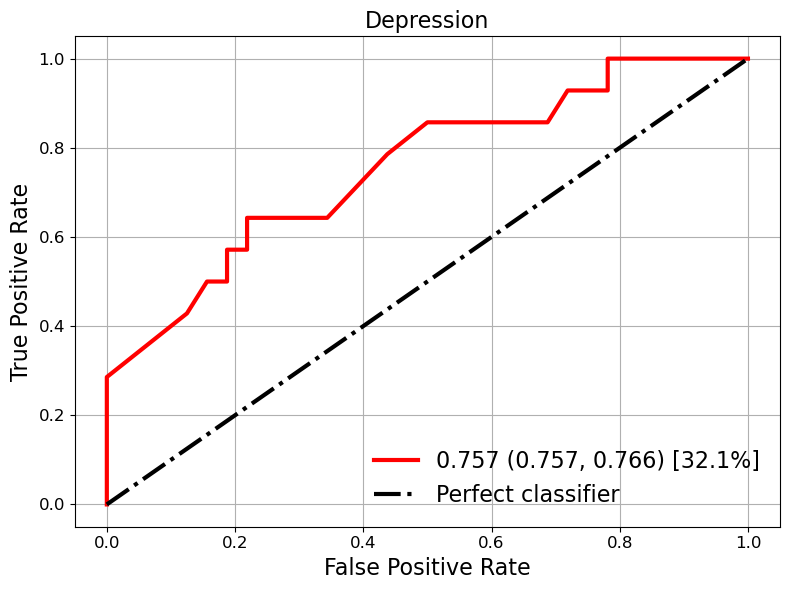

In [157]:
############################### 1) Bootstrapping to calculate confidence intervals
iterations = 1000
bootstrap_aucs_internal = []

for _ in tqdm(range(iterations)):
    # Generate bootstrap sample indices
    sample_indices = np.random.choice(len(y_test_i), len(y_test_i), replace=True)

    # Internal test set bootstrapping
    y_test_bootstrap = y_test_i[sample_indices]
    y_test_preds_bootstrap = y_test_preds[sample_indices]
    if len(np.unique(y_test_bootstrap)) > 1:  # Ensure both classes are present
        auc_bootstrap_int = roc_auc_score(y_test_bootstrap, y_test_preds_bootstrap)
        bootstrap_aucs_internal.append(auc_bootstrap_int)

# Compute confidence intervals
bootstrap_aucs_internal = np.array(bootstrap_aucs_internal)
auc_diff_int = bootstrap_aucs_internal - base_auc

low_auc_int = base_auc + np.percentile(auc_diff_int, ((1.0 - alpha) / 2.0) * 100)
high_auc_int = base_auc + np.percentile(auc_diff_int, (alpha + ((1.0 - alpha) / 2.0)) * 100)
#low_auc_int = np.percentile(bootstrap_aucs_internal, (1.0 - alpha) / 2.0 * 100)
#high_auc_int = np.percentile(bootstrap_aucs_internal, (alpha + (1.0 - alpha) / 2.0) * 100)


prevalence_int = y_val_i.sum() + y_test_i.sum() # y_train_i.sum() + y_val_i.sum() + y_test_i.sum()
prevalence_int = round((prevalence_int / (len(y_val_i) + len(y_test_i))) * 100, 2) # round((prevalence_int / (len(y_train_i) + len(y_val_i) + len(y_test_i))) * 100, 2)

cmap = plt.get_cmap("RdBu_r")
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap=cmap)
internal_color = sm.to_rgba(0.2)  # red shade
external_color = sm.to_rgba(0.8)  # blue shade

fpr, tpr, _ = roc_curve(y_test_i, y_test_preds)

fig = plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=3, label=f'{base_auc:.3f} ({low_auc_int:.3f}, {high_auc_int:.3f}) [{prevalence_int}%]')
plt.plot([0, 1], [0, 1], 'k-.', label='Perfect classifier', lw=3)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title(f'{Your_class}', fontsize=16)
plt.legend(loc='lower right', fontsize=16, framealpha=0)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True)
fig.patch.set_alpha(0.0)
fig.set_facecolor('none')
folder = "figures"
if not os.path.exists(folder):
    os.makedirs(folder)
plt.savefig(f'{folder}/AUROC_{Your_class}.png', dpi=600, transparent=True)
plt.show()

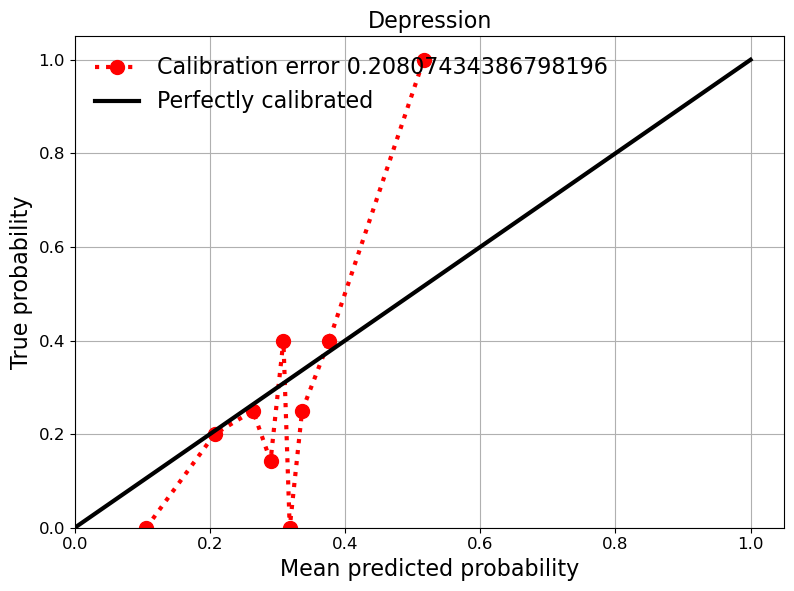

In [160]:
################### 2) calibration

# Apply calibrated model to test predictions
fig = plt.figure(figsize=(8, 6))

prob_true, prob_pred = calibration_curve(y_test_i, y_test_preds, n_bins=10, strategy='quantile')
# bin_counts = np.histogram(y_test_preds, bins=10)[0]
# total = np.sum(bin_counts)
# ece = np.sum((bin_counts / total) * np.abs(prob_true - prob_pred))

bin_ids = np.digitize(y_test_preds, np.quantile(y_test_preds, np.linspace(0, 1, len(prob_true) + 1)[1:-1]))
ece = 0
total = len(y_test_preds)

for i in range(len(prob_true)):
    bin_mask = bin_ids == i
    bin_size = np.sum(bin_mask)
    if bin_size == 0:
        continue
    ece += (bin_size / total) * abs(prob_true[i] - prob_pred[i])

plt.plot(prob_pred, prob_true, marker='o', linestyle=':', label=f'Calibration error {ece}', color='red', linewidth=3, markersize=10)

plt.plot([0, 1], [0, 1], label='Perfectly calibrated', color='black', linewidth=3)
max_val = max(prob_pred.max(), prob_true.max())
plt.xlim(0, max_val * 1.05)
plt.ylim(0, max_val * 1.05)
plt.xlabel('Mean predicted probability', fontsize=16)
plt.ylabel('True probability', fontsize=16)
plt.title(f"{Your_class}", fontsize=16)
plt.legend(fontsize=16, framealpha=0)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=12)  # Set both x and y tick label font size

# Remove background
fig.patch.set_alpha(0.0)  # Make figure background transparent
fig.set_facecolor('none')  # Make axes background transparent
folder = "figures"
if not os.path.exists(folder):
    os.makedirs(folder)
plt.savefig(f"{folder}/calibration_{Your_class}.png", dpi=600, transparent=True)
plt.show()

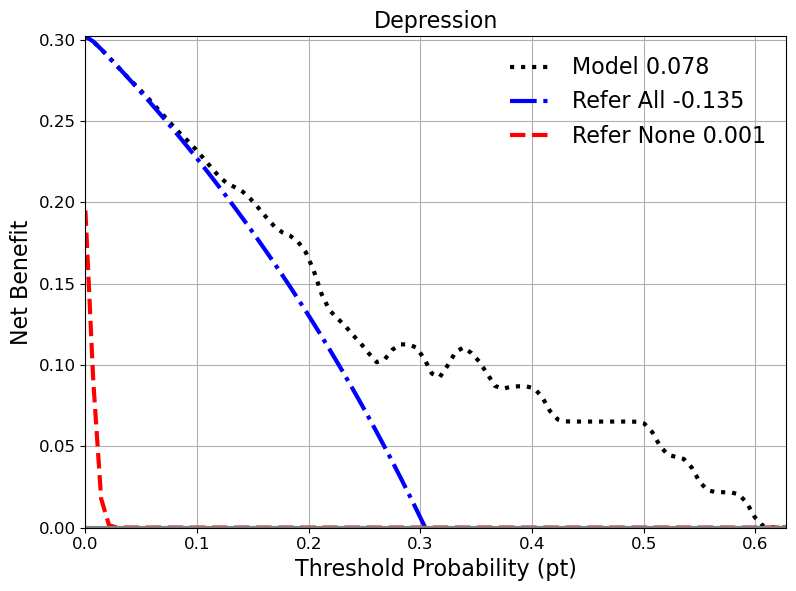

In [159]:
#################### 3) net benefit

# Net benefit computation function
def compute_net_benefit(y_true, y_prob, thresholds):
    N = len(y_true)
    net_benefits = []

    for pt in thresholds:
        y_pred = y_prob >= pt
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        net_benefit = (TP / N) - (FP / N) * (pt / (1 - pt))
        net_benefits.append(net_benefit)

    return net_benefits

max_prob = y_test_preds.max()
thresholds = np.linspace(0, max_prob+0.1, 100)

# Compute net benefit for the model int
nb_model = compute_net_benefit(y_test_i, y_test_preds, thresholds)
nb_all = compute_net_benefit(y_test_i, np.ones_like(y_test_preds), thresholds)
nb_none = compute_net_benefit(y_test_i, np.zeros_like(y_test_preds), thresholds)

from scipy.ndimage import gaussian_filter1d

nb_model = gaussian_filter1d(nb_model, sigma=1)
nb_none = gaussian_filter1d(nb_none, sigma=1)
nb_all = gaussian_filter1d(nb_all, sigma=1)

# nb_model_e = gaussian_filter1d(nb_model_e, sigma=1)
# nb_none_e = gaussian_filter1d(nb_none_e, sigma=1)
# nb_all_e = gaussian_filter1d(nb_all_e, sigma=1)

from numpy import trapz

# AUNBCs
aunbc_int = trapz(nb_model, thresholds)
aunbc_int_all = trapz(nb_all, thresholds)
aunbc_int_none = trapz(nb_none, thresholds)

fig = plt.figure(figsize=(8, 6))
plt.plot(thresholds, nb_model, label=f"Model {round(aunbc_int,3)}", linestyle=':', color='black', linewidth=3)
plt.plot(thresholds, nb_all, label=f"Refer All {round(aunbc_int_all,3)}", linestyle='-.', color='blue', linewidth=3)
plt.plot(thresholds, nb_none, label=f"Refer None {round(aunbc_int_none,3)}", linestyle='--', color='red', linewidth=3)

plt.axhline(0, color='grey', linewidth=3)

nb_model = np.array(nb_model)
idx_neg = np.where(nb_model < 0)[0]

# Set y_min to the second negative value, or to the first if only one exists, or to a default
if len(idx_neg) >= 2:
    y_min = nb_model[idx_neg[1]]
elif len(idx_neg) == 1:
    y_min = nb_model[idx_neg[0]]
else:
    y_min = -0.0001  # or another default

max_val = max(np.max(nb_model), np.max(nb_all), np.max(nb_none))

plt.ylim(y_min, max_val)

idx_x = np.where(nb_model <= 0)[0]
if len(idx_x) > 0:
    x_max = thresholds[idx_x[0]]
else:
    x_max = thresholds[-1]
plt.xlim(thresholds[0], x_max)

plt.xlabel("Threshold Probability (pt)", fontsize=16)
plt.ylabel("Net Benefit", fontsize=16)
plt.title(f"{Your_class}", fontsize=16)
plt.legend(fontsize=16, framealpha=0)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=12)  # Set both x and y tick label font size

# Remove background
fig.patch.set_alpha(0.0)  # Make figure background transparent
fig.set_facecolor('none')  # Make axes background transparent
folder = "figures"
if not os.path.exists(folder):
    os.makedirs(folder)
plt.savefig(f"{folder}/net_benefit_{Your_class}.png", dpi=600, transparent=True)
plt.show()

In [30]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.utils import resample
import matplotlib.pyplot as plt
import shap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

Your_class = 'Depression' 
x's and y's names?

x_train
x_val
x_test
y_train
y_val
y_test_i
    

model = XGBClassifier(use_label_encoder=False, 
                      eval_metric='logloss')

model.fit(x_train, y_train_i,
         eval_set=[(x_val, y_val_i)],
         early_stopping_rounds=10,
         verbose=False)

y_test_preds = model.predict_proba(x_test)[:, 1]

base_auc = roc_auc_score(y_test_i, y_test_preds)

############################### 1) Bootstrapping to calculate confidence intervals
iterations = 1000
bootstrap_aucs_internal = []

for _ in tqdm(range(iterations)):

# Generate bootstrap sample indices
sample_indices = np.random.choice(len(y_test_i), len(y_test_i), replace=True)

# Internal test set bootstrapping
y_test_bootstrap = y_test_i[sample_indices]
y_test_preds_bootstrap = y_test_preds[sample_indices]
if len(np.unique(y_test_bootstrap)) > 1:  # Ensure both classes are present
    auc_bootstrap_int = roc_auc_score(y_test_bootstrap, y_test_preds_bootstrap)
    bootstrap_aucs_internal.append(auc_bootstrap_int)
Compute confidence intervals
bootstrap_aucs_internal = np.array(bootstrap_aucs_internal)
auc_diff_int = bootstrap_aucs_internal - base_auc
low_auc_int = base_auc + np.percentile(auc_diff_int, ((1.0 - alpha) / 2.0) * 100)
high_auc_int = base_auc + np.percentile(auc_diff_int, (alpha + ((1.0 - alpha) / 2.0)) * 100)

prevalence_int = y_train.sum() + y_val.sum() + y_test_i.sum()
prevalence_int = round((prevalence_int / (len(y_train_i) + len(y_val_i) + len(y_test_i)))*100,2)

cmap = plt.get_cmap("RdBu_r")
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap=cmap)
internal_color = sm.to_rgba(0.2)  # This gives a red shade (closer to 0 is more red)
external_color = sm.to_rgba(0.8)  # This gives a blue shade (closer to 1 is more blue)

fpr, tpr, _ = roc_curve(y_test_i, y_test_preds)
fpr_ext, tpr_ext, _ = roc_curve(y_test_ext_i, y_test_ext_preds)

fig = plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=3, label=f'{base_auc:.3f} ({low_auc_int:.3f}, {high_auc_int:.3f}) [{prevalence_int}%]')
plt.plot([0, 1], [0, 1], 'k-.', label='Perfect classifier', lw=3)  # Changing the random line to dot-dash
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title(f'{Your_class}', fontsize=16)
plt.legend(loc='lower right', fontsize=16, framealpha=0)
plt.tick_params(axis='both', which='major', labelsize=12)  # Set both x and y tick label font size
plt.tight_layout()
plt.grid(True)
fig.patch.set_alpha(0.0)  # Make figure background transparent
fig.set_facecolor('none')  # Make axes background transparent
plt.savefig(f'figures/AUROC_{Your_class}.png', dpi=600, transparent=True)

################### 2) calibration

Sort for isotonic fit
probs_val = model.predict_proba(x_val)[:, 1]
sorted_idx = np.argsort(probs_val)
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(probs_val[sorted_idx], y_val_i[sorted_idx])

4. Apply calibrated model to test predictions
y_test_preds = model.predict_proba(x_test)[:, 1]
y_test_preds = iso.transform(y_test_preds)

fig = plt.figure(figsize=(8, 6))

prob_true, prob_pred = calibration_curve(y_test_i, y_test_preds, n_bins=10, strategy='quantile')
bin_counts = np.histogram(y_test_preds, bins=10)[0]
total = np.sum(bin_counts)
ece = np.sum((bin_counts / total) * np.abs(prob_true - prob_pred))
plt.plot(prob_pred, prob_true, marker='o', linestyle=':', label=f'Calibration error {ece}', color='red', linewidth=3, markersize=10)

plt.plot([0, 1], [0, 1], label='Perfectly calibrated', color='black', linewidth=3)
max_val = max(prob_pred.max(), prob_true.max())
plt.xlim(0, max_val * 1.05)
plt.ylim(0, max_val * 1.05)
plt.xlabel('Mean predicted probability', fontsize=16)
plt.ylabel('True probability', fontsize=16)
plt.title(f"{Your_class}", fontsize=16)
plt.legend(fontsize=16, framealpha=0)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=12)  # Set both x and y tick label font size

Remove background
fig.patch.set_alpha(0.0)  # Make figure background transparent
fig.set_facecolor('none')  # Make axes background transparent
plt.savefig(f"figures/calibration_{Your_class}.png", dpi=600, transparent=True)
plt.show()

#################### 3) net benefit

Net benefit computation function
def compute_net_benefit(y_true, y_prob, thresholds):
    N = len(y_true)
    net_benefits = []

for pt in thresholds:
    y_pred = y_prob >= pt
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    net_benefit = (TP / N) - (FP / N) * (pt / (1 - pt))
    net_benefits.append(net_benefit)

return net_benefits
max_prob = y_test_preds.max()
thresholds = np.linspace(0, max_prob+0.1, 100)

Compute net benefit for the model int
nb_model = compute_net_benefit(y_test_i, y_test_preds, thresholds)
nb_all = compute_net_benefit(y_test_i, np.ones_like(y_test_preds), thresholds)
nb_none = compute_net_benefit(y_test_i, np.zeros_like(y_test_preds), thresholds)

from scipy.ndimage import gaussian_filter1d

nb_model = gaussian_filter1d(nb_model, sigma=1)
nb_none = gaussian_filter1d(nb_none, sigma=1)
nb_all = gaussian_filter1d(nb_all, sigma=1)

nb_model_e = gaussian_filter1d(nb_model_e, sigma=1)
nb_none_e = gaussian_filter1d(nb_none_e, sigma=1)
nb_all_e = gaussian_filter1d(nb_all_e, sigma=1)

from numpy import trapz

AUNBCs
aunbc_int = trapz(nb_model, thresholds)
aunbc_int_all = trapz(nb_all, thresholds)
aunbc_int_none = trapz(nb_none, thresholds)

fig = plt.figure(figsize=(8, 6))
plt.plot(thresholds, nb_model, label=f"Model {round(aunbc_int,3)}", linestyle=':',color='black', linewidth=3)
plt.plot(thresholds, nb_all, label=f"Refer All {round(aunbc_int_all,3)}", linestyle='-.', color='blue', linewidth=3)
plt.plot(thresholds, nb_none, label=f"Refer None {round(aunbc_int_none,3)}", linestyle='--', color='red', linewidth=3)

plt.axhline(0, color='grey', linewidth=3)

nb_model = np.array(nb_model)
idx_neg = np.where(nb_model < 0)[0]

Set y_min to the second negative value, or to the first if only one exists, or to a default
if len(idx_neg) >= 2:
    y_min = nb_model[idx_neg[1]]
elif len(idx_neg) == 1:
    y_min = nb_model[idx_neg[0]]
else:
    y_min = -0.0001  # or another default

max_val = max(np.max(nb_model), np.max(nb_all), np.max(nb_none))

plt.ylim(y_min, max_val)

idx_x = np.where(nb_model <= 0)[0]
if len(idx_x) > 0:
    x_max = thresholds[idx_x[0]]
else:
    x_max = thresholds[-1]
plt.xlim(thresholds[0], x_max)

plt.xlabel("Threshold Probability (pt)", fontsize=16)
plt.ylabel("Net Benefit", fontsize=16)
plt.title(f"{Your_class}", fontsize=16)
plt.legend(fontsize=16, framealpha=0)
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=12)  # Set both x and y tick label font size

Remove background
fig.patch.set_alpha(0.0)  # Make figure background transparent
fig.set_facecolor('none')  # Make axes background transparent
plt.savefig(f"figures/net_benefit_{Your_class}.png", dpi=600, transparent=True)
plt.show()

IndentationError: expected an indented block after 'for' statement on line 38 (769932712.py, line 41)